In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2, venn3, venn3_circles, venn2_circles
import seaborn as sns
import itertools as it

In [2]:
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

In [3]:
threshold = 0.2

Dataset_name = f'OTUs_decontam_either_{threshold}_grouped_all_vs_all_2'
Table_data_path = f"/Users/asobolev/skoltech/articles/kits/results/decontam/{Dataset_name}.tsv"

#Path to metadata.
Table_metadata_path = "/Users/asobolev/skoltech/articles/kits/metadata_nofc_ordered.csv"

#Output path.
Pathout = "/Users/asobolev/skoltech/articles/kits/plots/reproducibility/"

In [4]:
# read metadata
Input_metadata = pd.read_csv(Table_metadata_path, sep=',', header=0, index_col=1)
# Input_metadata = Input_metadata.replace({'B&T': 'DNeasy', 'PowSoi': 'DNeasy'})  # merge kits into one
controls = Input_metadata[Input_metadata['Sample type'].isin(["control", "kitome"])].index.tolist()
Input_metadata = Input_metadata.loc[~Input_metadata.index.isin(controls)]
# Input_metadata = Input_metadata.loc[Input_metadata['Group'] != 'PowFec']
kits = list(Input_metadata['Group'].unique())

In [5]:
common_kits = ['MagBac', 'MagMic', 'MagSoi', 'MagSto', 'SilMet', 'SilSoi', 'SkySto', 'SkySoi']
sample_types = list(set((Input_metadata["Sample type"])))
kits_dict = {}
for t in sample_types:
    if t == 'water':
        kits_dict[t] = common_kits + ['B&T']
    elif t == 'feces':
        kits_dict[t] = common_kits + ['PowSoi', 'PowFec']
    elif t in ('organism', 'soil'):
        kits_dict[t] = common_kits + ['PowSoi']
    else:
        kits_dict[t] = common_kits

In [6]:

#Read input metadata table.
Sample_type_ar = list(Input_metadata.loc[:, "Sample type"])
Kit_type_list = list(Input_metadata.loc[:, "Group"])
Samples_ID_ar = list(Input_metadata.index)

Sample_kit_types = []
Sample_kit_types_dict = {}
for i in range(len(Sample_type_ar)):
    Sample_kit_type = Sample_type_ar[i] + '_' + Kit_type_list[i] + '_' + str((i % 3) + 1)
    Sample_kit_types.append(Sample_kit_type)
    Sample_kit_types_dict[Samples_ID_ar[i]] = Sample_kit_type

In [7]:
#Read input data table.
Input_data = pd.read_csv(Table_data_path, sep='\t', header=0, index_col=0)
# print(Input_data.head())
Input_data = Input_data.drop([str(i) for i in controls], axis=1)
Input_data_col_names_old = list(Input_data.columns)

#Rename samples.
Input_data_col_names_new = []
for col_name_old in Input_data_col_names_old:
    col_name_new = Sample_kit_types_dict[int(col_name_old)]
    Input_data_col_names_new.append(col_name_new)

Input_data_nh = Input_data.set_axis(Input_data_col_names_new, axis=1)

In [8]:
#Prepare kit names lists.
# Kit_types_list_short = []
Sample_types_list_short = []
Sample_kit_combinations = []
for sample_name in Input_data_col_names_new:
    sample_name = sample_name[:-2]
    # print(sample_name)
    kit_name = sample_name.split('_')[1]
    # if (kit_name not in Kit_types_list_short) and (kit_name not in ['PowFec']):
    #     Kit_types_list_short.append(kit_name)
    sample_type = sample_name.split('_')[0]
    if sample_type not in Sample_types_list_short:
        Sample_types_list_short.append(sample_type)
    if sample_name in Sample_kit_combinations:
        continue
    else:
        Sample_kit_combinations.append(sample_name)

# Sample_kit_combinations.sort(key=lambda x: x.split('_')[0], reverse=True)


In [9]:
all_combinations = [f'{s}_{k}' for s, k in it.product(sample_types, kits)]
Abs_replication_df = pd.DataFrame(columns=Sample_types_list_short, index=kits)
Abs_replication_df = Abs_replication_df.astype(float)

ncol = len(set(Kit_type_list))
nrow = len(sample_types)

fig, plots = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol * 2.5, nrow * 2.5), dpi=100)

repl_otu_abs = {}
repl_otu_rel = {}

# Define the new row order
row_order = ['water', 'soil', 'organism', 'feces']

for j, sk_comb in enumerate(all_combinations):

    sample_type = sk_comb.split('_')[0]
    kit_type = sk_comb.split('_')[1]
    
    x_coord = j % ncol
    y_coord = row_order.index(sample_type)
    

    if x_coord == 0:
        plots[y_coord, x_coord].text(-1.2, 0.3, sk_comb.split('_')[0], verticalalignment='center', rotation=90, fontsize=16)
        
    if y_coord == 0:
        plots[y_coord, x_coord].set_title(sk_comb.split('_')[1], loc='center', size=16)

    if sk_comb not in Sample_kit_combinations:
        continue

    tech_set_df = Input_data_nh.filter(regex=f'^{sample_type}', axis=1).filter(regex=f'^{sk_comb}', axis=1)
    
    tech_reps = [f'{sk_comb}_{i}' for i in range(1, 4)]

    Tech_set_df_filt_abs = tech_set_df[(tech_set_df[tech_reps[0]] > 0) & (tech_set_df[tech_reps[1]] > 0) & (tech_set_df[tech_reps[2]] > 0)] # Absolute replication.
    Tech_set_df_filt_rel = tech_set_df[(tech_set_df[tech_reps[0]] > 0) | (tech_set_df[tech_reps[1]] > 0) | (tech_set_df[tech_reps[2]] > 0)] # Relaxed replication.
    Abs_rep_list = list(Tech_set_df_filt_abs.index)
    Rel_rep_list = list(Tech_set_df_filt_rel.index)
    repl_otu_abs[sk_comb] = Abs_rep_list
    repl_otu_rel[sk_comb] = Rel_rep_list
    
    Rep_1 = set(list(tech_set_df[tech_set_df[tech_reps[0]] > 0].index))
    Rep_2 = set(list(tech_set_df[tech_set_df[tech_reps[1]] > 0].index))
    Rep_3 = set(list(tech_set_df[tech_set_df[tech_reps[2]] > 0].index))

    venn3([Rep_1, Rep_2, Rep_3], set_labels = ('Rep 1', 'Rep 2', 'Rep 3'), ax=plots[y_coord, x_coord])
    venn3_circles([Rep_1, Rep_2, Rep_3], ax=plots[y_coord, x_coord])
    Abs_replication_level = int(100 * float(len(Abs_rep_list)) / len(Rel_rep_list))
    plots[y_coord, x_coord].text(0.4, -0.8, f'{len(Abs_rep_list)}/{len(Rel_rep_list)} OTUs\ntriplicated ({Abs_replication_level}%)', size=8)
    
    #Store replication level.
    Abs_replication_df.loc[kit_type, sample_type] = Abs_replication_level
    
    j += 1

plt.savefig(f'{Pathout}Tech_replicates_venn.png', dpi=320)
plt.savefig(f'{Pathout}Tech_replicates_venn.svg', dpi=320)
plt.close()

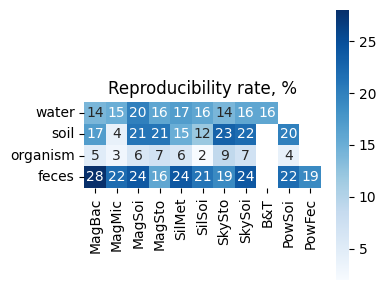

In [10]:
Min=Abs_replication_df.min().min()
Max=Abs_replication_df.max().max()

fig, ax=plt.subplots(figsize = (4, 3))

#sns.heatmap(Control_df, annot=True)
ax.set_title('Reproducibility rate, %')
sns.heatmap(Abs_replication_df.T, annot=True, square=True, vmin=Min, vmax=Max, cmap='Blues', ax=ax)

plt.tight_layout()
plt.savefig(f'{Pathout}Absolute_reproducibility_heatmap.png', dpi=300)
plt.savefig(f'{Pathout}Absolute_reproducibility_heatmap.svg', dpi=300)

In [10]:
## Investigate reproducibility between kits using Absolute replication.

OTU_replication_numbers_by_st = {}
sample_type_list = ['water', 'soil', 'organism', 'feces']
for sample_type in sample_type_list:
    OTU_replication_numbers = {}
    for sk_comb, OTU_list in repl_otu_abs.items():
        if sample_type in sk_comb:
            for OTU in OTU_list:
                if OTU in OTU_replication_numbers:
                    OTU_replication_numbers[OTU] += 1
                else:
                    OTU_replication_numbers[OTU] = 1
    OTU_replication_numbers_by_st[sample_type] = OTU_replication_numbers


Rep_num_by_sample_type = {}
Universal_OTU_num_dict = {}
Universal_OTUs_by_sample_type = {'water': [], 'soil': [], 'organism': [], 'feces': []}
for sample_type, st_data in OTU_replication_numbers_by_st.items():
    kit_list = kits_dict[sample_type]
    Universal_OTU_num_dict[sample_type] = 0
    Rep_num_ar = []
    # print(st_data)
    for OTU_name, OTU_rep_num in st_data.items():
        Rep_num_ar.append(OTU_rep_num)
        if sample_type == 'soil':
            n_kits = len(kit_list) - 1
        else:
            n_kits = len(kit_list)
        if OTU_rep_num == n_kits:
            Universal_OTU_num_dict[sample_type] += 1
            Universal_OTUs_by_sample_type[sample_type].append(OTU_name)
    Rep_num_by_sample_type[sample_type]=Rep_num_ar

    Rep_num_d = dict((i, Rep_num_ar.count(i)) for i in range(1, len(kit_list) + 1))
    print(sample_type, f'{Rep_num_ar.count(len(kit_list) - 1)}/{sum([v for v in Rep_num_d.values()])}')
    fig = plt.figure(figsize=(3, 3), dpi=100)
    plt.bar(np.array(range(1, len(kit_list) + 1)), list(Rep_num_d.values()), align='edge', facecolor='blue', edgecolor='black', alpha=0.5)
    # plt.hist(Rep_num_ar, bins=range(1, 8 + 2, 1), facecolor='blue', edgecolor='black', alpha=0.5)
    plt.xticks(np.array(range(1, len(kit_list) + 1)) + 0.5, range(1, len(kit_list) + 1, 1))
    plt.xlim([0, len(kit_list) + 1])
    plt.xlabel('Number of kits')
    plt.ylabel('Number of OTUs')
    plt.title(f'{sample_type} samples')
    plt.tight_layout()
    plt.savefig(f'{Pathout}Absolute_replication_for_{sample_type}.png', dpi=300)
    plt.savefig(f'{Pathout}Absolute_replication_for_{sample_type}.svg', dpi=300)
    plt.close()

water 75/934
soil 154/1788
organism 1/83
feces 13/333


154

In [13]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(Universal_OTUs_by_sample_type, orient='index').T

# Save the DataFrame as a CSV file
df.to_csv(f'{Pathout}Universal_OTUs_by_sample_type.csv', index=False)

In [10]:
def barplot_OTUs_types(otu_num_dict, Types_name_ar, Color_ar, kit_types_list, Sample_type, Dataset_name, path_out):
    
    fig, ax = plt.subplots()
    
    j = 0
    x_coords = []
    for kit_name, OTU_num_ar in otu_num_dict.items():
    
        Num_cumul=0
        for i in range(len(OTU_num_ar)):
            if j==0:
                ax.bar(j, OTU_num_ar[i], 0.65, color=Color_ar[i], bottom=Num_cumul, tick_label=kit_name, label=f'{Types_name_ar[i]}')
            else:
                ax.bar(j, OTU_num_ar[i], 0.65, color=Color_ar[i], bottom=Num_cumul, tick_label=kit_name)
            Num_cumul+=OTU_num_ar[i]
        
        x_coords.append(j)
        j+=1

    #ax.set_xlim([-0.5,0.5])
    ax.tick_params(axis='x', which='major', labelsize=12)

    ax.set_xticks(x_coords, labels=kit_types_list, minor=False, size=12, rotation=90)
    ax.set_ylabel('Number of OTUs', size=12)
    #ax.set_xlabel('DNA-extraction kits', size=12)
    ax.set_title(Sample_type, size=15)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    
    #Place legend outside of a graph. Taken from: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    box=ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(fontsize=12, ncol=1, loc='upper left', frameon=False, markerscale=1, handlelength=0.7, handletextpad=0.3, columnspacing=0.7, bbox_to_anchor=(1, 0.95))
    plt.tight_layout(rect=[0,0,0.7,1])
    plt.savefig(f'{path_out}{Sample_type}_{Dataset_name}_OTUs_types_barplot.png', dpi=300)
    plt.savefig(f'{path_out}{Sample_type}_{Dataset_name}_OTUs_types_barplot.svg', dpi=300)    

    return

water MagBac
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
46/452/888/452
water MagMic
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
81/260/853/562
water MagSoi
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
85/517/849/739
water MagSto
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
14/285/920/762
water SilMet
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
32/412/902/821
water SilSoi
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
24/386/910/853
water SkySto
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
6/291/928/862
water SkySoi
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
37/421/897/900
water B&T
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
34/419/900/934
soil MagBac
Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU
105/697/1683/697
soil MagMic
U

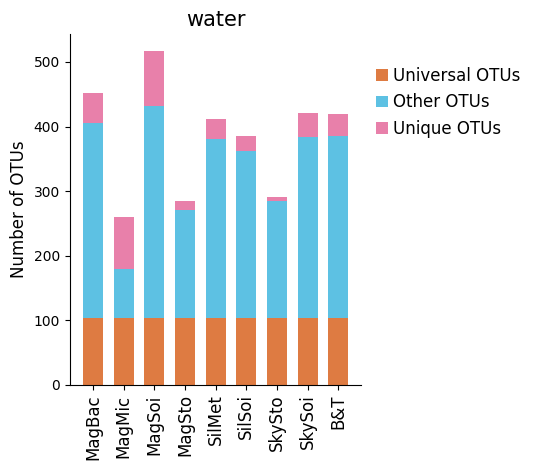

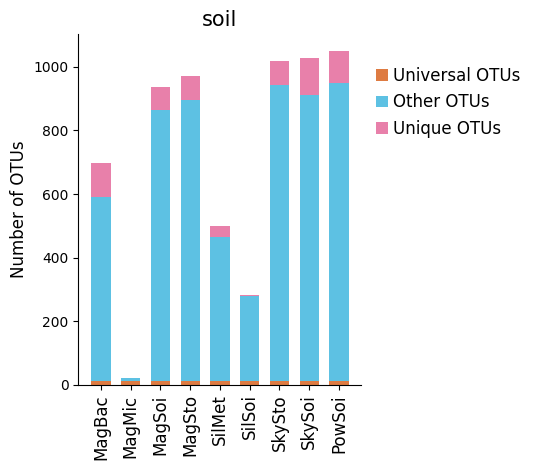

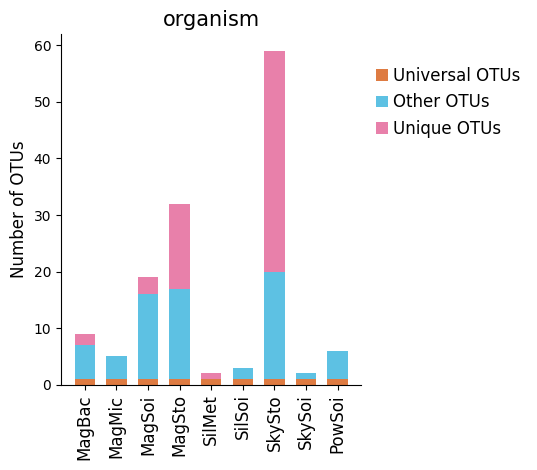

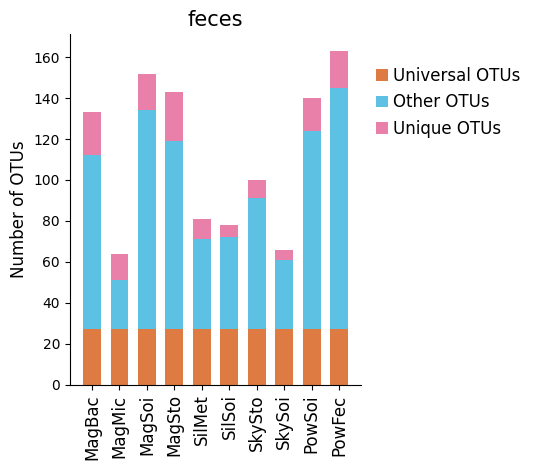

In [13]:
# sample_type_list = ['Sediment', 'Water', 'Gut flora']
Color_ar=['#de7b42', '#5dc1e3', '#e880aa']
OTU_types_list=['Universal OTUs', 'Other OTUs', 'Unique OTUs']

for sample_type in sample_type_list:
    OTU_num_dict = {}
    Kit_types_list_short = kits_dict[sample_type]
    total_OTUs = set()
    
    for kit_name_sel in Kit_types_list_short:
        Selected_comb = f'{sample_type}_{kit_name_sel}'
        Selected_kit_OTU_nr = set(repl_otu_abs[Selected_comb])
        total_OTUs.update(Selected_kit_OTU_nr)
        
        Other_kits_OTU = set()
        for kit_name_oth in Kit_types_list_short:
            if kit_name_sel != kit_name_oth:
                Other_kits_OTU.update(repl_otu_abs[f'{sample_type}_{kit_name_oth}'])
        
        Unique_OTU = Selected_kit_OTU_nr - Other_kits_OTU
        
        print(f'{sample_type} {kit_name_sel}')
        print("Unique OTUs num/Selected kit's OTU num/Other kits OTU/Total num of OTU")
        print(f'{len(Unique_OTU)}/{len(Selected_kit_OTU_nr)}/{len(Other_kits_OTU)}/{len(total_OTUs)}')
        
        Number_of_universal_OTUs = Universal_OTU_num_dict[sample_type]
        Number_of_unique_OTUs = len(Unique_OTU)
        Number_of_other_OTUs = len(Selected_kit_OTU_nr) - Number_of_universal_OTUs - Number_of_unique_OTUs
        
        OTU_num_dict[kit_name_sel] = [Number_of_universal_OTUs, Number_of_other_OTUs, Number_of_unique_OTUs]
    
    barplot_OTUs_types(OTU_num_dict, OTU_types_list, Color_ar, Kit_types_list_short, sample_type, Dataset_name, Pathout)


In [254]:
OTU_replication_numbers_by_st

{'water': {'OTU_1': 6,
  'OTU_2': 7,
  'OTU_9': 2,
  'OTU_13': 9,
  'OTU_16': 9,
  'OTU_19': 9,
  'OTU_22': 9,
  'OTU_33': 9,
  'OTU_34': 9,
  'OTU_46': 9,
  'OTU_47': 9,
  'OTU_52': 9,
  'OTU_56': 9,
  'OTU_61': 9,
  'OTU_67': 9,
  'OTU_73': 9,
  'OTU_74': 9,
  'OTU_78': 9,
  'OTU_80': 9,
  'OTU_82': 9,
  'OTU_83': 9,
  'OTU_92': 9,
  'OTU_93': 9,
  'OTU_95': 9,
  'OTU_98': 9,
  'OTU_101': 9,
  'OTU_104': 9,
  'OTU_106': 9,
  'OTU_107': 9,
  'OTU_108': 9,
  'OTU_109': 9,
  'OTU_114': 9,
  'OTU_118': 9,
  'OTU_119': 9,
  'OTU_123': 9,
  'OTU_128': 9,
  'OTU_136': 9,
  'OTU_138': 9,
  'OTU_143': 9,
  'OTU_148': 9,
  'OTU_149': 9,
  'OTU_151': 9,
  'OTU_152': 9,
  'OTU_154': 9,
  'OTU_160': 1,
  'OTU_165': 9,
  'OTU_166': 8,
  'OTU_167': 9,
  'OTU_169': 8,
  'OTU_172': 9,
  'OTU_174': 9,
  'OTU_176': 9,
  'OTU_178': 9,
  'OTU_182': 9,
  'OTU_186': 9,
  'OTU_188': 9,
  'OTU_190': 9,
  'OTU_191': 9,
  'OTU_199': 9,
  'OTU_202': 9,
  'OTU_203': 9,
  'OTU_210': 9,
  'OTU_211': 9,
  'OTU_217'

In [265]:
print({k: len(v) for k, v in repl_otu_rel.items()}, '\n')
print({k: len(v) for k, v in repl_otu_abs.items()}, '\n')

{'organism_MagSto': 455, 'organism_MagMic': 131, 'organism_MagSoi': 272, 'organism_MagBac': 158, 'organism_SilMet': 31, 'organism_SilSoi': 111, 'organism_SkySoi': 26, 'organism_SkySto': 593, 'organism_PowSoi': 129, 'water_MagSto': 1759, 'water_MagMic': 1638, 'water_MagSoi': 2481, 'water_MagBac': 3035, 'water_SilMet': 2385, 'water_SilSoi': 2309, 'water_SkySoi': 2563, 'water_SkySto': 1974, 'water_B&T': 2561, 'soil_MagSto': 4426, 'soil_MagMic': 484, 'soil_MagSoi': 4341, 'soil_MagBac': 3955, 'soil_SilMet': 3302, 'soil_SilSoi': 2232, 'soil_SkySoi': 4516, 'soil_SkySto': 4351, 'soil_PowSoi': 5010, 'feces_MagSto': 877, 'feces_MagMic': 282, 'feces_MagSoi': 624, 'feces_MagBac': 472, 'feces_SilMet': 335, 'feces_SilSoi': 366, 'feces_SkySoi': 265, 'feces_SkySto': 516, 'feces_PowSoi': 629, 'feces_PowFec': 828} 

{'organism_MagSto': 32, 'organism_MagMic': 5, 'organism_MagSoi': 19, 'organism_MagBac': 9, 'organism_SilMet': 2, 'organism_SilSoi': 3, 'organism_SkySoi': 2, 'organism_SkySto': 59, 'organism_

In [37]:
## Investigate reproducibility between kits using Relaxed replication.
OTU_replication_numbers_by_st = {}

for sample_type in sample_type_list:
    OTU_replication_numbers = {}
    for sk_comb, OTU_list in repl_otu_rel.items():
        if sample_type in sk_comb:
            for OTU in OTU_list:
                if OTU in OTU_replication_numbers:
                    OTU_replication_numbers[OTU] += 1
                else:
                    OTU_replication_numbers[OTU] = 1
    OTU_replication_numbers_by_st[sample_type] = OTU_replication_numbers



Rep_num_by_sample_type = {}
for sample_type, st_data in OTU_replication_numbers_by_st.items():
    kit_list = kits_dict[sample_type]
    Rep_num_ar = []
    for OTU_name, OTU_rep_num in st_data.items():
        Rep_num_ar.append(OTU_rep_num)
    Rep_num_by_sample_type[sample_type] = Rep_num_ar
    Rep_num_d = dict((i, Rep_num_ar.count(i)) for i in range(1, len(kit_list) + 1))
    fig = plt.figure(figsize=(3, 3), dpi=100)
    plt.bar(np.array(range(1, len(kit_list) + 1)), list(Rep_num_d.values()), align='edge', facecolor='blue', edgecolor='black', alpha=0.5)

    plt.xticks(np.array(range(1, len(kit_list) + 1)) + 0.5, range(1, len(kit_list) + 1))
    plt.xlim([0, len(kit_list) + 1])
    plt.xlabel('Number of kits')
    plt.ylabel('Number of OTUs')
    plt.title(f'{sample_type} samples')
    plt.tight_layout()
    plt.savefig(f'{Pathout}Relaxed_replication_for_{sample_type}.svg', dpi=300)
    plt.savefig(f'{Pathout}Relaxed_replication_for_{sample_type}.png', dpi=300)
    plt.close()

In [54]:
## Method 1. OTU/ASV should be in all 3 tech replicates to be included - Absolute replication.
## Method 2. OTU/ASV should be in either of 3 tech replicates to be included - Relaxed replication.

{'water': 629, 'soil': 629, 'organism': 629, 'feces': 0}